In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from keras.optimizers import SGD
import matplotlib as mpl
import seaborn as sns
import category_encoders as ce
import os
import pickle
import gc
from tqdm import tqdm
from IPython.display import display, HTML

In [14]:
def encode_text_features(encode_decode, data_frame, encoder_isa=None, encoder_mem_type=None):
    # Implement Categorical OneHot encoding for ISA and mem-type
    if encode_decode == 'encode':
        encoder_isa = ce.one_hot.OneHotEncoder(cols=['isa'])
        encoder_mem_type = ce.one_hot.OneHotEncoder(cols=['mem-type'])
        encoder_isa.fit(data_frame, verbose=1)
        df_new1 = encoder_isa.transform(data_frame)
        encoder_mem_type.fit(df_new1, verbose=1)
        df_new = encoder_mem_type.transform(df_new1)
        encoded_data_frame = df_new
    else:
        df_new1 = encoder_isa.transform(data_frame)
        df_new = encoder_mem_type.transform(df_new1)
        encoded_data_frame = df_new
        
    return encoded_data_frame, encoder_isa, encoder_mem_type

In [118]:
def load_data():
    '''
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)'''
    
    df = pd.read_csv('\\Dataset_CSV\\all_datasets\\dijkstra.csv')
    print('Original DataFrame:\n')
    display(df.head())
    print('DF-Columns - Total Columns - Total Rows:\n')
    print(df.columns, len(df.columns), len(df))
    encoded_data_frame, encoder_isa, encoder_mem_type = encode_text_features('encode', df, encoder_isa = None, 
                                                                             encoder_mem_type=None)
    print('Encoded Data Frame:\n')
    display(encoded_data_frame.head())
    print('Its Columns:\n')
    print(encoded_data_frame.columns)
    total_data = encoded_data_frame.drop(columns = ['arch', 'arch1'])
    print('Columns Now: \n')
    print(total_data.columns)
    total_data = total_data.fillna(0)
    X_columns = total_data.drop(columns = 'PS').columns
    # X = total_data.drop(columns = ['runtime','PS']).to_numpy()
    X = total_data.drop(columns = ['PS']).to_numpy()
    Y = total_data['runtime'].to_numpy()
    print('X and Y Shape\n')
    print(X.shape, Y.shape)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    print('X_train- X_test -Y_train- Y_test\n')
    print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.fit_transform(X_test)
    return(X_train, Y_train, X_test, Y_test, X, Y, scaler)
    
(X_train, y_train,X_test, y_test, X, Y, scaler) = load_data()


Original DataFrame:



arch  cpu-clock     isa  l1d_assoc  \
0  IntelCorei97900X_DDR42666_2GB        3.3  X86_64          8   
1  IntelCorei97900X_DDR42666_3GB        3.3  X86_64          8   
2  IntelCorei97900X_DDR42666_4GB        3.3  X86_64          8   
3  IntelCorei97900X_DDR42666_6GB        3.3  X86_64          8   
4  IntelCorei97900X_DDR42666_7GB        3.3  X86_64          8   

   l1d_cache_lines  l1d_shared_by_threads  l1d_size  l2_assoc  l2_cache_lines  \
0               64                      1        32        16              64   
1               64                      1        32        16              64   
2               64                      1        32        16              64   
3               64                      1        32        16              64   
4               64                      1        32        16              64   

   l2_shared_by_threads  ...  l3_cache_lines  l3_shared_by_threads  l3_size  \
0                     1  ...              64                    10       16   
1                     1  ...              64                    10       16   
2                     1  ...              64                    10       16   
3                     1  ...              64                    10       16   
4                     1  ...              64                    10       16   

   mem-size  mem-type  mem_clock num-cpus                              arch1  \
0         2      DDR4       2666       10  IntelCorei97900X_DDR42666_2GB_100   
1         3      DDR4       2666       10  IntelCorei97900X_DDR42666_3GB_100   
2         4      DDR4       2666       10  IntelCorei97900X_DDR42666_4GB_100   
3         6      DDR4       2666       10  IntelCorei97900X_DDR42666_6GB_100   
4         7      DDR4       2666       10  IntelCorei97900X_DDR42666_7GB_100   

    PS runtime  
0  100   25523  
1  100   25523  
2  100   25523  
3  100   25523  
4  100   25523  

[5 rows x 22 columns]

DF-Columns - Total Columns - Total Rows:

Index(['arch', 'cpu-clock', 'isa', 'l1d_assoc', 'l1d_cache_lines',
       'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
       'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
       'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type', 'mem_clock',
       'num-cpus', 'arch1', 'PS', 'runtime'],
      dtype='object') 22 475
Encoded Data Frame:



arch  cpu-clock  isa_1  isa_2  l1d_assoc  \
0  IntelCorei97900X_DDR42666_2GB        3.3      1      0          8   
1  IntelCorei97900X_DDR42666_3GB        3.3      1      0          8   
2  IntelCorei97900X_DDR42666_4GB        3.3      1      0          8   
3  IntelCorei97900X_DDR42666_6GB        3.3      1      0          8   
4  IntelCorei97900X_DDR42666_7GB        3.3      1      0          8   

   l1d_cache_lines  l1d_shared_by_threads  l1d_size  l2_assoc  l2_cache_lines  \
0               64                      1        32        16              64   
1               64                      1        32        16              64   
2               64                      1        32        16              64   
3               64                      1        32        16              64   
4               64                      1        32        16              64   

   ...  mem-size  mem-type_1  mem-type_2  mem-type_3  mem-type_4  mem_clock  \
0  ...         2           1           0           0           0       2666   
1  ...         3           1           0           0           0       2666   
2  ...         4           1           0           0           0       2666   
3  ...         6           1           0           0           0       2666   
4  ...         7           1           0           0           0       2666   

   num-cpus                              arch1   PS  runtime  
0        10  IntelCorei97900X_DDR42666_2GB_100  100    25523  
1        10  IntelCorei97900X_DDR42666_3GB_100  100    25523  
2        10  IntelCorei97900X_DDR42666_4GB_100  100    25523  
3        10  IntelCorei97900X_DDR42666_6GB_100  100    25523  
4        10  IntelCorei97900X_DDR42666_7GB_100  100    25523  

[5 rows x 26 columns]

Its Columns:

Index(['arch', 'cpu-clock', 'isa_1', 'isa_2', 'l1d_assoc', 'l1d_cache_lines',
       'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
       'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
       'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type_1',
       'mem-type_2', 'mem-type_3', 'mem-type_4', 'mem_clock', 'num-cpus',
       'arch1', 'PS', 'runtime'],
      dtype='object')
Columns Now: 

Index(['cpu-clock', 'isa_1', 'isa_2', 'l1d_assoc', 'l1d_cache_lines',
       'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
       'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
       'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type_1',
       'mem-type_2', 'mem-type_3', 'mem-type_4', 'mem_clock', 'num-cpus', 'PS',
       'runtime'],
      dtype='object')
X and Y Shape

(475, 23) (475,)
X_train- X_test -Y_train- Y_test

(380, 23) (95, 23) (380,) (95,)


In [119]:
X_train[0]

array([2.7000e+00, 1.0000e+00, 0.0000e+00, 8.0000e+00, 6.4000e+01,
       1.0000e+00, 3.2000e+01, 4.0000e+00, 6.4000e+01, 1.0000e+00,
       2.5600e+02, 1.2000e+01, 6.4000e+01, 2.0000e+00, 3.0000e+00,
       4.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       1.6000e+03, 2.0000e+00, 3.1233e+04])

In [120]:
X.shape, Y.shape

((475, 23), (475,))

In [121]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [193]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=23, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_253 (Dense)            (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_190 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_254 (Dense)            (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_191 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_255 (Dense)            (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_192 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
dense_256 (Dense)            (None, 23)              

In [194]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=23))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()


Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_257 (Dense)            (None, 1024)              24576     
_________________________________________________________________
leaky_re_lu_193 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_258 (Dense)            (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_194 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_259 (Dense)            (None, 256)             

In [195]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_64 (Sequential)   (None, 23)                706327    
_________________________________________________________________
sequential_65 (Sequential)   (None, 1)                 680961    
Total params: 1,387,288
Trainable params: 706,327
Non-trainable params: 680,961
_________________________________________________________________


In [196]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)


In [197]:
def training(epochs=1, batch_size = 10):
    
    #Loading the data
    (X_train, y_train, X_test, y_test, X, Y, scaler) = load_data()
    batch_count = X_train.shape[0] / batch_size  # 380/10 = 38
    
    # Creating GAN
    generator= create_generator() 
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1, epochs+1):
        print("Epoch **************************%d*************************" %e)
        for k in (range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            indexes = np.random.randint(low=0, high = X_train.shape[0], size = batch_size)
            image_batch = X_train[indexes]
            
            
            #Construct different batches of real and fake data 
            X = np.concatenate([image_batch, generated_images])
            
            # Labels for real and fake data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            #y_dis[:batch_size] = y_train[indexes]
            #y_dis[batch_size:] = np.random.randint(np.min(Y), np.max(Y), size = batch_size)
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
            print('\nDiscriminator Output:', discriminator.predict(X), '\n')
            
            #Tricking the noised input of the Generator as real data
            noise = np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            # y_gen = np.random.randint(np.min(Y), np.max(Y), size = batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        # if e == 1 or e % 20 == 0:
            #return 
            # plot_generated_images(e, generator)
    return generator, X_train, y_train 
generator, X_train, y_train = training(5,10)

Original DataFrame:



arch  cpu-clock     isa  l1d_assoc  \
0  IntelCorei97900X_DDR42666_2GB        3.3  X86_64          8   
1  IntelCorei97900X_DDR42666_3GB        3.3  X86_64          8   
2  IntelCorei97900X_DDR42666_4GB        3.3  X86_64          8   
3  IntelCorei97900X_DDR42666_6GB        3.3  X86_64          8   
4  IntelCorei97900X_DDR42666_7GB        3.3  X86_64          8   

   l1d_cache_lines  l1d_shared_by_threads  l1d_size  l2_assoc  l2_cache_lines  \
0               64                      1        32        16              64   
1               64                      1        32        16              64   
2               64                      1        32        16              64   
3               64                      1        32        16              64   
4               64                      1        32        16              64   

   l2_shared_by_threads  ...  l3_cache_lines  l3_shared_by_threads  l3_size  \
0                     1  ...              64                    10       16   
1                     1  ...              64                    10       16   
2                     1  ...              64                    10       16   
3                     1  ...              64                    10       16   
4                     1  ...              64                    10       16   

   mem-size  mem-type  mem_clock num-cpus                              arch1  \
0         2      DDR4       2666       10  IntelCorei97900X_DDR42666_2GB_100   
1         3      DDR4       2666       10  IntelCorei97900X_DDR42666_3GB_100   
2         4      DDR4       2666       10  IntelCorei97900X_DDR42666_4GB_100   
3         6      DDR4       2666       10  IntelCorei97900X_DDR42666_6GB_100   
4         7      DDR4       2666       10  IntelCorei97900X_DDR42666_7GB_100   

    PS runtime  
0  100   25523  
1  100   25523  
2  100   25523  
3  100   25523  
4  100   25523  

[5 rows x 22 columns]

DF-Columns - Total Columns - Total Rows:

Index(['arch', 'cpu-clock', 'isa', 'l1d_assoc', 'l1d_cache_lines',
       'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
       'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
       'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type', 'mem_clock',
       'num-cpus', 'arch1', 'PS', 'runtime'],
      dtype='object') 22 475
Encoded Data Frame:



arch  cpu-clock  isa_1  isa_2  l1d_assoc  \
0  IntelCorei97900X_DDR42666_2GB        3.3      1      0          8   
1  IntelCorei97900X_DDR42666_3GB        3.3      1      0          8   
2  IntelCorei97900X_DDR42666_4GB        3.3      1      0          8   
3  IntelCorei97900X_DDR42666_6GB        3.3      1      0          8   
4  IntelCorei97900X_DDR42666_7GB        3.3      1      0          8   

   l1d_cache_lines  l1d_shared_by_threads  l1d_size  l2_assoc  l2_cache_lines  \
0               64                      1        32        16              64   
1               64                      1        32        16              64   
2               64                      1        32        16              64   
3               64                      1        32        16              64   
4               64                      1        32        16              64   

   ...  mem-size  mem-type_1  mem-type_2  mem-type_3  mem-type_4  mem_clock  \
0  ...         2           1           0           0           0       2666   
1  ...         3           1           0           0           0       2666   
2  ...         4           1           0           0           0       2666   
3  ...         6           1           0           0           0       2666   
4  ...         7           1           0           0           0       2666   

   num-cpus                              arch1   PS  runtime  
0        10  IntelCorei97900X_DDR42666_2GB_100  100    25523  
1        10  IntelCorei97900X_DDR42666_3GB_100  100    25523  
2        10  IntelCorei97900X_DDR42666_4GB_100  100    25523  
3        10  IntelCorei97900X_DDR42666_6GB_100  100    25523  
4        10  IntelCorei97900X_DDR42666_7GB_100  100    25523  

[5 rows x 26 columns]

Its Columns:

Index(['arch', 'cpu-clock', 'isa_1', 'isa_2', 'l1d_assoc', 'l1d_cache_lines',
       'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
       'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
       'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type_1',
       'mem-type_2', 'mem-type_3', 'mem-type_4', 'mem_clock', 'num-cpus',
       'arch1', 'PS', 'runtime'],
      dtype='object')
Columns Now: 

Index(['cpu-clock', 'isa_1', 'isa_2', 'l1d_assoc', 'l1d_cache_lines',
       'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
       'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
       'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type_1',
       'mem-type_2', 'mem-type_3', 'mem-type_4', 'mem_clock', 'num-cpus', 'PS',
       'runtime'],
      dtype='object')
X and Y Shape

(475, 23) (475,)
X_train- X_test -Y_train- Y_test

(380, 23) (95, 23) (380,) (95,)
Epoch **************************1*************

 [0.22896685]] 


Discriminator Output: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.13672054]
 [0.20600414]
 [0.1619299 ]
 [0.1679765 ]
 [0.1983577 ]
 [0.19243503]
 [0.25179487]
 [0.18763223]
 [0.18819796]
 [0.1711929 ]] 


Discriminator Output: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.17366508]
 [0.20484194]
 [0.16994408]
 [0.17366639]
 [0.15855572]
 [0.21939155]
 [0.18367445]
 [0.16928554]
 [0.16045292]
 [0.19862185]] 


Discriminator Output: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.17429537]
 [0.13741279]
 [0.15151119]
 [0.2319861 ]
 [0.1336619 ]
 [0.21695974]
 [0.19505809]
 [0.23011483]
 [0.15711457]
 [0.14586322]] 


Discriminator Output: [[0.        ]
 [0.        ]
 [0.        ]


In [198]:
noise.shape

(10, 100)

In [182]:
generated_images.shape

(10, 23)

In [183]:
image_batch.shape

(10, 22)

In [184]:
X.shape

(475, 23)

In [185]:
y_dis

array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [199]:
y_gen

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [219]:
noise = np.random.normal(0,1, [batch_size, 100])

# Generate fake MNIST images from noised input
generated_images = g.predict(noise)  # (10,22)
generated_images.shape

(10, 23)

([<matplotlib.axis.XTick at 0x348a3c99b0>,
 <a list of 22 Text xticklabel objects>)

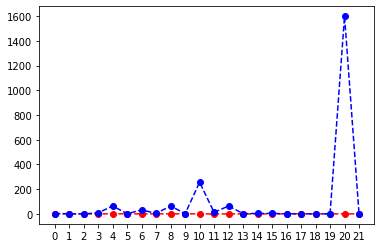

In [220]:
plt.plot(generated_images[0,:-1], '--ro')
plt.plot(X_train[0,:-1], '--bo')
plt.xticks(np.arange(0,22))

In [222]:
generated_images[0]

array([ 0.35655743,  0.01161883, -0.08276401,  0.00749136,  0.1345616 ,
        0.47081432, -0.22768408,  0.17333621,  0.13477056,  0.3589251 ,
       -0.27430093, -0.33482042, -0.40939882, -0.16037735, -0.19302256,
       -0.09391382,  0.15333961,  0.01632238,  0.06563549,  0.2168463 ,
        0.03701702, -0.31466392, -0.17991854], dtype=float32)

In [208]:
X_train[0]

array([2.7000e+00, 1.0000e+00, 0.0000e+00, 8.0000e+00, 6.4000e+01,
       1.0000e+00, 3.2000e+01, 4.0000e+00, 6.4000e+01, 1.0000e+00,
       2.5600e+02, 1.2000e+01, 6.4000e+01, 2.0000e+00, 3.0000e+00,
       4.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       1.6000e+03, 2.0000e+00, 3.1233e+04])

In [84]:
np.random.randint(low=0, high = X_train.shape[0], size = batch_size)

array([ 16, 281, 241, 184, 111, 300, 224,  18,  37,  57])

In [99]:
np.max(Y), np.min(Y)

(212496, 18659)